<a href="https://colab.research.google.com/github/ErikaRiv/HateSpeech/blob/main/Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ver Davidson et al. 2017. El código se basa principalmente en el código del artículo mencionado.

    Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017, May). Automated hate speech detection and the problem of offensive language. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 11, No. 1, pp. 512-515).



Descargar los datos:

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id   = '1e6PTWoc-KLHsY1qsMXZ8HhaRmDvmtoLb',
                                    dest_path = '/content/datos/data.p',
                                    unzip     = False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Librerías**

In [9]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import word_tokenize
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
plt.style.available
%matplotlib inline
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
data = pd.read_pickle("/content/datos/data.p")

In [15]:
data.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [17]:
data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Collect just the tweet and its classification:

* 0 stands for Offensive Language 

* 1 stands for Hate Speech

* 2 stands for Neither.

In [19]:
data2 = data[["class","tweet"]]

In [20]:
tweets = data2.tweet
clase  = data2[["class"]]

We have 24783 tweets to work with

In [21]:
len(tweets)

24783

Next, plot the histogram with respect to the classes.

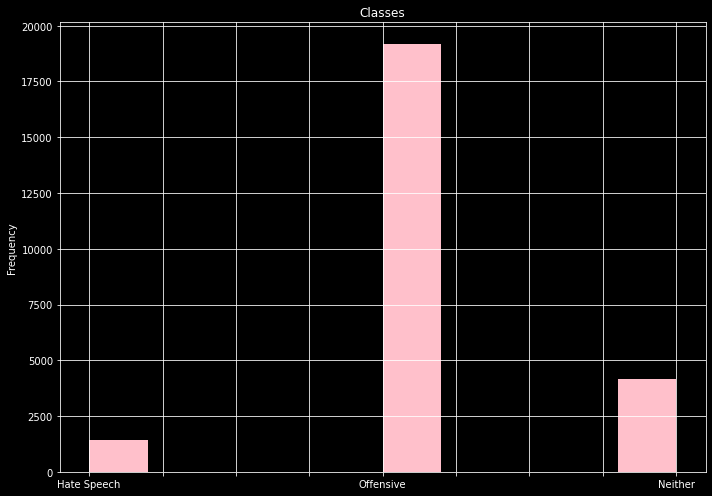

In [23]:
plt.style.available
plt.style.use('dark_background')
fig, ax = plt.subplots(1, 1,figsize =(10, 7),tight_layout = True)
ax.hist(data2['class'],color='pink')
plt.title('Classes')
names = ['','Hate Speech','','', '','Offensive','','', '', 'Neither']
ax.set_xticklabels(names)
ax.set_ylabel('Frequency')
plt.grid()
plt.savefig('histo_data.png')
plt.show()

Esto muestra que existe una gran acumulación de tweets clasificados como *Offensive Language*

Procesamiento de los tweets:

In [28]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt","RT"] 
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'#Spaces 
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') #URL
    mention_regex = '@[\w\-]+' #Menciones
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet): #Enlista letras de cada string
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip() #Letras en minúsculas
    tokens = [stemmer.stem(t) for t in tweet.split()] #Pasar sufijos y prefijos a su raíz
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()


#Se sobre-escribe la función de tokenizer con TFIDF, considerando las funciones de arrriba
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [29]:
#Ejemplo de uso de expressiones regulares
for tweet in tweets[:5]:
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    token = tokenize(parsed_text)
    basic_tokeniz = basic_tokenize(parsed_text)
    print('original:',tweet,'\n','Pased:',parsed_text,'\n Token: \n ', token, '\n basic_tokenize', basic_tokeniz )

original: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 
 Pased: !!! RT : As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 
 Token: 
  ['r', 't', 'a', 's', 'a', 'w', 'o', 'm', 'a', 'n', 'y', 'o', 'u', 's', 'h', 'o', 'u', 'l', 'd', 'n', 't', 'c', 'o', 'm', 'p', 'l', 'a', 'i', 'n', 'a', 'b', 'o', 'u', 't', 'c', 'l', 'e', 'a', 'n', 'i', 'n', 'g', 'u', 'p', 'y', 'o', 'u', 'r', 'h', 'o', 'u', 's', 'e', 'a', 'm', 'p', 'a', 's', 'a', 'm', 'a', 'n', 'y', 'o', 'u', 's', 'h', 'o', 'u', 'l', 'd', 'a', 'l', 'w', 'a', 'y', 's', 't', 'a', 'k', 'e', 't', 'h', 'e', 't', 'r', 'a', 's', 'h', 'o', 'u', 't'] 
 basic_tokenize ['!', '!', '!', 'r', 't', 'a', 's', 'a', 'w', 'o', 'm', 'a', 'n', 'y', 'o', 'u', 's', 'h', 'o', 'u', 'l', 'd', 'n', 't', 'c', 'o', 'm', 'p', 'l', 'a', 'i', 'n', 'a', 'b', 'o', 'u', 't', 'c', 'l', 'e', 'a', 'n', 'i', 'n', '

In [30]:
vectorizer.fit_transform(tweets).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


array([[1.29163073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.29163073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.29163073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

La función anterior arroja una matriz cuyas columas son:

In [31]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())} 
idf_vals = vectorizer.idf_ #Inverse Data Frequency (Peso de palabras (raras))
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
tweets[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [33]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens) #Parts of a speech (clasifica en tipo de palabra)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [34]:
tweet_tags[0]

'. . . NN VBD DT NN DT NN NN VBD DT JJ NN NN JJ NN NN JJ JJ NN NN JJ NN NN IN JJ NN VBD DT NN VBP DT NN NN JJ NN NN NN VBZ DT NN NN VBP NN JJ NN NN NN JJ NN NN JJ JJ NN NN . DT NN NN DT NN DT NN DT JJ NN NN JJ NN NN JJ JJ NN VBZ DT NN WRB DT NN NN VBZ DT NN NN NN NN NN NN VBZ DT JJ NN NN JJ NN . . .'

In [35]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [36]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = { v:i for i, v in enumerate(pos_vectorizer.get_feature_names()) }

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [39]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [40]:
feats = get_feature_array(tweets)

In [42]:
feats

array([[  8.3 ,  79.94,  30.  , ...,   1.  ,   0.  ,   0.  ],
       [  4.7 ,  90.13,  19.  , ...,   1.  ,   0.  ,   0.  ],
       [  5.8 ,  89.25,  23.  , ...,   2.  ,   0.  ,   1.  ],
       ...,
       [  3.1 ,  96.03,  15.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.6 , 103.05,   8.  , ...,   0.  ,   0.  ,   0.  ],
       [  9.8 ,  55.22,  27.  , ...,   0.  ,   1.  ,   0.  ]])

In [45]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

Finalmente vamos a comparar las siguientes dos matrices: la matriz de TFiDF y la matriz resultado de concatenar la matriz TFiDF, POS y otros factores de interés (other feature names).

In [46]:
M = tfidf
X = pd.DataFrame(M)
np.savetxt( "Matriz1.txt", M)

In [47]:
N = np.concatenate([tfidf,pos,feats],axis=1)
N = pd.DataFrame(N)
np.savetxt( "Matriz2.txt", N)

In [48]:
y = data['class'].astype(int)
np.savetxt( "y.txt", y)



---



---

